In [18]:
import numpy as np
import rasterio

combined_file_path = "../datasets/output.tif"
with rasterio.open(combined_file_path) as src:
    print(src.meta)
    width = src.meta['width']
    height = src.meta['height']
    channels = src.meta['count']
    # 分块保存ndarray，每块大小为 256 * 256
    block_size = 256
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = src.read(window=(
                (i, min(i + block_size, height)),
                (j, min(j + block_size, width)))
            )
            
            if block.shape[1:] != (block_size, block_size):
                pad_height = block_size - block.shape[1]
                pad_width = block_size - block.shape[2]
                block = np.pad(block, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')
            
            # 保存 block 数组
            np.save(f'../dataV2/train/blocks/block_{i}_{j}.npy', block)
    # data = src.read()
    # 保存 data 数组
    # np.save('data.npy', data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 43641, 'height': 39291, 'count': 5, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0651, 0.0, 258121.02701859066,
       0.0, -0.0651, 4518292.6701675765)}


In [19]:
from tif2pngs import Tif2Pngs, ROOT
import os


mask_file_path = os.path.join(ROOT, 'datasets', 'standard.tif')
tif2pngs = Tif2Pngs(mask_file_path, os.path.join(ROOT, 'dataV2', 'train', 'masks'))
tif2pngs.process_tif()

100%|██████████| 26334/26334 [00:20<00:00, 1270.77it/s]


In [20]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from shutil import copyfile

random.seed(3407)

def split_train_val(val_ratio=0.2, image_prefix='block', mask_prefix='standard', image_suffix='.npy', mask_suffix='.png'):
    source_dir = os.path.join(ROOT, 'dataV2', 'train')
    target_dir = os.path.join(ROOT, 'dataV2', 'val')

    files = os.listdir(os.path.join(source_dir, 'blocks'))

    num_files = len(files)
    num_val_files = int(num_files * val_ratio)
    val_files = random.sample(files, num_val_files)
    # 将抽取的文件复制到目标目录
    for file in tqdm(val_files):
        # 复制图像文件
        copyfile(os.path.join(source_dir, 'blocks', file), os.path.join(target_dir, 'blocks', file))
        # 复制掩码文件
        copyfile(os.path.join(source_dir, 'masks', file.replace(image_prefix, mask_prefix)).replace(image_suffix, mask_suffix),
                 os.path.join(target_dir, 'masks', file.replace(image_prefix, mask_prefix)).replace(image_suffix, mask_suffix))
        # 删除源目录下的文件
        os.remove(os.path.join(source_dir, 'blocks', file))
        os.remove(os.path.join(source_dir, 'masks', file.replace(image_prefix, mask_prefix).replace(image_suffix, mask_suffix)))
        
split_train_val(0.2)

100%|██████████| 5266/5266 [00:35<00:00, 149.90it/s]


In [1]:
from SegmentationDatasetV2 import SegmentationDatasetV2
import os
from SegmentationDataset import ROOT
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch
import random

torch.manual_seed(3407)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3407)
random.seed(3407)

# 阶段二，加载数据集
train_dir = os.path.join(ROOT, 'dataV2', 'train')
val_dir = os.path.join(ROOT, 'dataV2', 'val')

# 创建数据集
train_dataset = SegmentationDatasetV2(root_dir=train_dir)
val_dataset = SegmentationDatasetV2(root_dir=val_dir)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [2]:
array, mask = train_dataset[0]
print(array.shape, mask.shape)

(5, 256, 256) torch.Size([3, 256, 256])


In [3]:
from visdom import Visdom
import numpy as np

viz = Visdom(env='my_windows')

epoches = [0]
losses = [0.1]
accuracies = [0]

loss_win = viz.line(
    X=np.array(epoches),
    Y=np.array(losses),
    opts=dict(showlegend=True))

score_win = viz.line(
    X=np.array(epoches),
    Y=np.array(accuracies),
    opts=dict(showlegend=True))

Setting up a new session...


In [4]:
from loss import FocalLoss
import torch
from segmentation_models_pytorch import Unet
from eval import cal_score_v2

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 创建模型
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             in_channels=5,
             classes=3,
             activation='softmax'
             ).to(device)

# 损失函数和优化器
loss_fn = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
accuracies = []

# 初始化最小loss为正无穷大
min_loss = float('inf')

# TODO 训练轮次改这里
epoch_num = 50

# 训练模型
for epoch in range(1, epoch_num + 1):
    model.train()
    for batch in train_loader:
        images, masks = batch
        # 将数据和模型都移动到GPU
        images = images.to(device)
        masks = masks.to(device)
        
        # 现在masks是一个一维的tensor，每个元素对应一个像素的类别索引
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # 更新列表
    losses.append(loss.item())
    score = cal_score_v2(model, val_loader)
    accuracies.append(score)
    
    viz.line(X=np.array([epoch]),
             Y=np.array([loss.item()]),
             win=loss_win, update='append')
    
    viz.line(X=np.array([epoch]),
             Y=np.array([score]),
             win=score_win, update='append')
        
    # 每个epoch结束时保存模型
    torch.save(model.state_dict(), f'../model/5_channel_model_epoch_{epoch}.pth')
    print(f'Epoch {epoch}, Loss: {loss.item()}, Score: {score}')


E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
E:\DataMining\corn-anomaly-detection\code\eval.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32).to(device)


Epoch 1, Loss: 0.08777572959661484, Score: 97.32706871858532
Epoch 2, Loss: 0.09863747656345367, Score: 97.43542559283611
Epoch 3, Loss: 0.08727432042360306, Score: 97.54113805461554
Epoch 4, Loss: 0.08975625038146973, Score: 97.28764679963444
Epoch 5, Loss: 0.08629350364208221, Score: 97.5480547541681
Epoch 6, Loss: 0.09071411192417145, Score: 97.62394477331362
Epoch 7, Loss: 0.08558455109596252, Score: 97.57902343147298
Epoch 8, Loss: 0.0869196355342865, Score: 97.57664241131566
Epoch 9, Loss: 0.08549880981445312, Score: 97.29343412857838
Epoch 10, Loss: 0.08546912670135498, Score: 97.63951302661309
Epoch 11, Loss: 0.08921966701745987, Score: 97.6491226445483
Epoch 12, Loss: 0.08574577420949936, Score: 97.63398468562328
Epoch 13, Loss: 0.10215772688388824, Score: 97.35965350622284
Epoch 14, Loss: 0.08604458719491959, Score: 97.50202531014111
Epoch 15, Loss: 0.08735252916812897, Score: 97.64316650112455
Epoch 16, Loss: 0.08738313615322113, Score: 97.18740072804533
Epoch 17, Loss: 0.08

In [60]:
from matplotlib import pyplot as plt
import numpy as np

one_hot_vector1 = torch.tensor([1., 0., 0.]).repeat(256, 256, 1)
one_hot_vector2 = torch.tensor([0., 1., 0.]).repeat(256, 256, 1)
one_hot_vector3 = torch.tensor([0., 0., 1.]).repeat(256, 256, 1)


i = 206
while i < len(val_dataset):
    image, mask = val_dataset[i]
    mask = mask.permute(1, 2, 0)
    comparison1 = mask == one_hot_vector1
    comparison2 = mask == one_hot_vector2
    comparison3 = mask == one_hot_vector3
    judge1 = comparison1.all(dim=2).any().item()
    judge2 = comparison2.all(dim=2).any().item()
    judge3 = comparison3.all(dim=2).any().item()
    if judge1 and judge2 and judge3:
        print(f"{i} {judge1} {judge2} {judge3}")
        break
    i += 1


447 True True True


In [61]:
image.shape

(5, 256, 256)

In [62]:
# 取 image 的[:3, :, :]，即前三个通道
image = image[:3, :, :]
print(type(image))
image.shape

<class 'numpy.ndarray'>


(3, 256, 256)

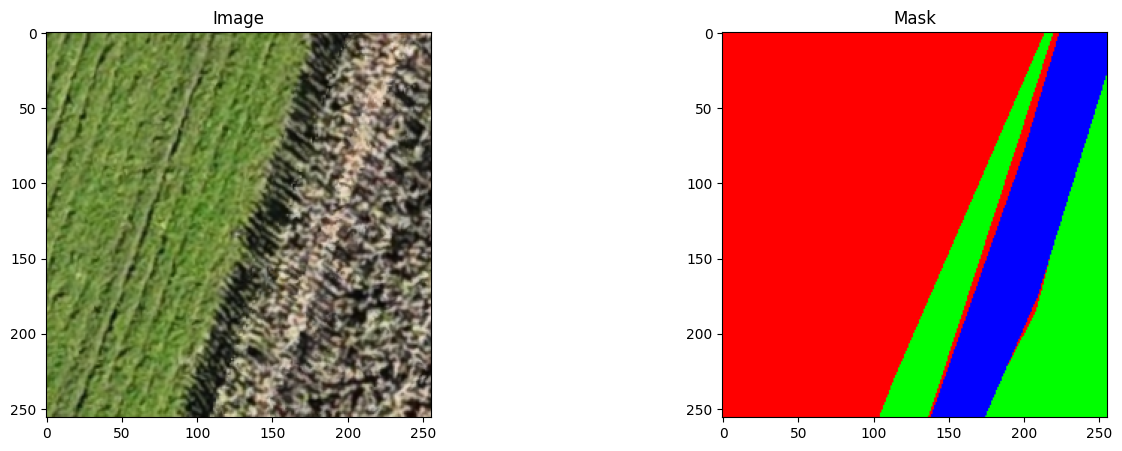

In [63]:
# 显示图像和掩码
image = np.transpose(image, (1, 2, 0)).astype(np.uint8)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.show()

In [6]:
import torch
from segmentation_models_pytorch import Unet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Unet(encoder_name='resnet34',
             encoder_weights='imagenet',
             in_channels=5,
             classes=3,
             activation='softmax'
             ).to(device)

model.load_state_dict(torch.load(f'../model/best_model_epoch_{5}.pth', weights_only=True))
model.eval()
pass

In [7]:
from matplotlib import pyplot as plt
import numpy as np

one_hot_vector1 = torch.tensor([1., 0., 0.]).repeat(256, 256, 1)
one_hot_vector2 = torch.tensor([0., 1., 0.]).repeat(256, 256, 1)
one_hot_vector3 = torch.tensor([0., 0., 1.]).repeat(256, 256, 1)


i = 446
while i < len(val_dataset):
    image, mask = val_dataset[i]
    mask = mask.permute(1, 2, 0)
    comparison1 = mask == one_hot_vector1
    comparison2 = mask == one_hot_vector2
    comparison3 = mask == one_hot_vector3
    judge1 = comparison1.all(dim=2).any().item()
    judge2 = comparison2.all(dim=2).any().item()
    judge3 = comparison3.all(dim=2).any().item()
    if judge1 and judge2 and judge3:
        print(f"{i} {judge1} {judge2} {judge3}")
        break
    i += 1

447 True True True


In [8]:
type(image)

numpy.ndarray

In [9]:
image_tensor = torch.tensor(image).unsqueeze(0).to(device)
image_tensor.shape

torch.Size([1, 5, 256, 256])

In [10]:
with torch.no_grad():
    # tmp = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    result = (output.squeeze().cpu().numpy())
    print(result.shape)

(3, 256, 256)


E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [11]:
result = np.where(result > 0.5, 255, 0)
result = torch.tensor(result, dtype=torch.uint8)

<class 'numpy.ndarray'>


TypeError: Invalid shape (256, 3, 256) for image data

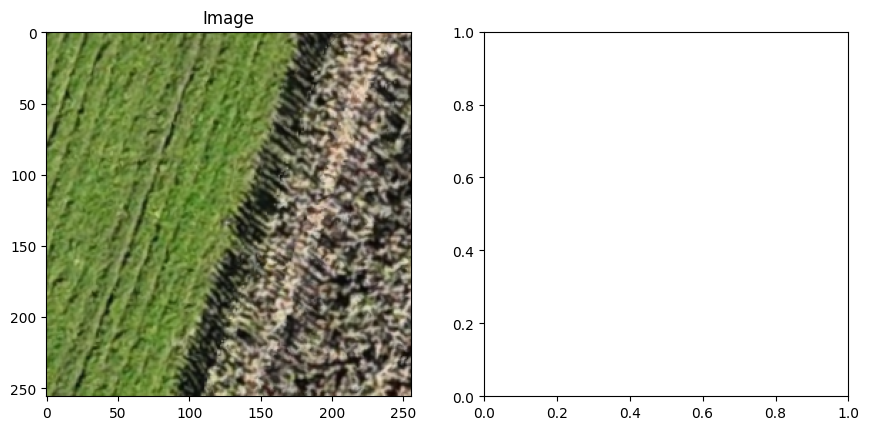

In [12]:
import matplotlib.pyplot as plt
# 取 image 的[:3, :, :]，即前三个通道
image1 = image[:3, :, :]
print(type(image))
# 显示图像和掩码
image1 = np.transpose(image1, (1, 2, 0)).astype(np.uint8)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image')
plt.subplot(1, 3, 2)
plt.imshow(mask.permute(1, 2, 0))
plt.title('Mask')
plt.subplot(1, 3, 3)
plt.imshow(result.permute(1, 2, 0))
plt.title('Result')
plt.show()


In [13]:
from eval import cal_score, cal_score_v2
score = cal_score_v2(model, val_dataset)

ValueError: expected 4D input (got 3D input)